In [25]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn import manifold, decomposition, linear_model, ensemble, neighbors, cross_validation
%matplotlib inline
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

from heamy.dataset import Dataset
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline

In [26]:
def rmse(x,y):
    return np.mean((x - y) ** 2) ** 0.5

## Подготовка данных (urls)

In [27]:
urls_train_df = pd.read_csv('data/url_domain_train', header=None, delimiter='\t')
urls_train_df.columns = ['id', 'url', 'count']
urls_train_df = urls_train_df[['id', 'url']]

In [28]:
urls_train_df.head()

,id,url
0,000000014B60815F65B38258011B6C01,login.rutracker.org
1,000000014B60815F65B38258011B6C01,rutracker.org
2,000000014C03DA2A47AC433A0C755201,admin.tour-spb.net
3,000000014C03DA2A47AC433A0C755201,czinfo.ru
4,000000014C03DA2A47AC433A0C755201,forumsostav.ru


In [29]:
urls_train_df = pd.DataFrame(urls_train_df.groupby('id')['url'].apply(lambda x: x.tolist()))
urls_train_df['id'] = urls_train_df.index
urls_train_df.index = range(len(urls_train_df))
urls_train_df.columns = ['urls', 'id']

In [30]:
urls_train_df.head()

,urls,id
0,"[id.rambler.ru, mail.rambler.ru, r0.ru]",000000013CB5719C0000A2C90002C101
1,"[1prime.ru, autorambler.ru, chellak.ru, docs.c...",00000001442BE24000001B7D00F50801
2,[bosch-korolev.ru],00000001448580F800003F1B31FB0901
3,"[aptekanizkihcen.ua, colady.ru, gorod.dp.ua, i...",0000000145BDB2FF000157971645E901
4,"[astrorok.ru, diets.ru, edaplus.info, eshzdoro...",000000014602771F0000DB9359714C01


In [31]:
age_train_df = pd.read_csv('data/age_profile_train', header=None, delimiter='\t')
age_train_df.columns = ['id', 'age']

In [32]:
age_train_df.head()

,id,age
0,000000013CB5719C0000A2C90002C101,53
1,00000001442BE24000001B7D00F50801,48
2,00000001448580F800003F1B31FB0901,28
3,0000000145BDB2FF000157971645E901,44
4,000000014602771F0000DB9359714C01,48


In [33]:
train_df = urls_train_df.merge(age_train_df, on='id', how='left')

In [34]:
train_df.head()

,urls,id,age
0,"[id.rambler.ru, mail.rambler.ru, r0.ru]",000000013CB5719C0000A2C90002C101,53
1,"[1prime.ru, autorambler.ru, chellak.ru, docs.c...",00000001442BE24000001B7D00F50801,48
2,[bosch-korolev.ru],00000001448580F800003F1B31FB0901,28
3,"[aptekanizkihcen.ua, colady.ru, gorod.dp.ua, i...",0000000145BDB2FF000157971645E901,44
4,"[astrorok.ru, diets.ru, edaplus.info, eshzdoro...",000000014602771F0000DB9359714C01,48


In [35]:
#   train_df

## Снижение размерности

In [36]:
topk = 300000
X, y = train_df.urls.values[:topk], train_df.age.values[:topk]

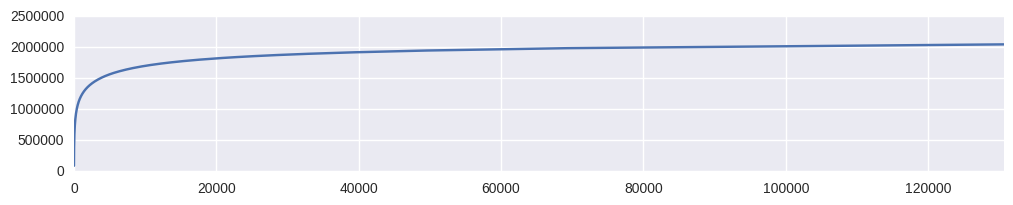

In [37]:
url_frequency = pd.Series([j for i in X for j in i]).value_counts()
url_frequency.index = range(len(url_frequency))

url_frequency.cumsum().plot(figsize=(12,2))

In [38]:
X = map(lambda x: ' '.join(x), X)
hw = HashingVectorizer(n_features=1000, non_negative=True).fit(X)
X = hw.transform(X).todense()

In [39]:
X.shape

(118603, 1000)

In [40]:
%%time

transformer = sklearn.decomposition.NMF(n_components=100)
X_nmf = transformer.fit_transform(X)

CPU times: user 20min 4s, sys: 8.43 s, total: 20min 13s
Wall time: 12min 43s


## Холдаут

In [41]:
itrain, itest = cross_validation.train_test_split(range(len(X)), test_size=1./3, random_state=0)
len(itrain), len(itest)

(79068, 39535)

## Обучение модели

In [42]:
rmse(y[itest], np.mean(y[itrain]))

12.546984607126014

In [43]:
reg = LinearRegression()
reg.fit(X[itrain, :], y[itrain])

pred_X = reg.predict(X[itest, :])
print rmse(y[itest], pred_X)

11.9053939779


In [44]:
reg = LinearRegression()
reg.fit(X_nmf[itrain, :], y[itrain])

pred_X_nmf = reg.predict(X_nmf[itest, :])
print rmse(y[itest], pred_X_nmf)

12.017606646


11.8814962719


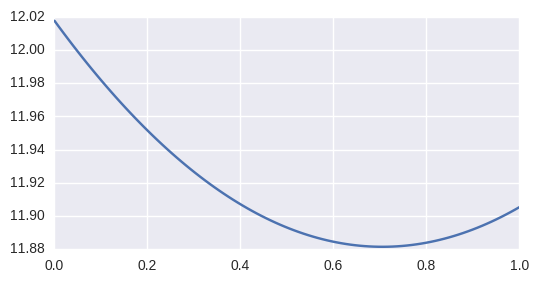

In [45]:
error = []
for w in np.linspace(0, 1, 100):
     error += [rmse(y[itest], pred_X * w + (1-w) * pred_X_nmf)]

pd.Series(error, index=np.linspace(0, 1, 100)).plot(figsize=(6,3))
print min(error)

## Blenging с помощью heamy
pip install heamy

https://github.com/rushter/heamy

In [46]:
from sklearn import pipeline, preprocessing, feature_extraction

In [47]:
# %%time

# обычный датасет
dataset1 = Dataset(X[itrain, :], y[itrain], X[itest, :])
# NMF
dataset2 = Dataset(X_nmf[itrain, :], y[itrain], X_nmf[itest, :])

# линейная модель на обычных данных
lr = Regressor(dataset=dataset1, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr')

# линейная модель на TFIDF от обычных данных
def tfidf_lr_(X_train, y_train, X_test, y_test=None, random_state=8888):
    model = pipeline.Pipeline([('tfidf', feature_extraction.text.TfidfTransformer()), 
                                ('linear_model', linear_model.LinearRegression())])
    model.fit(X_train, y_train)
    return model.predict(X_test)

tfidf_lr = Regressor(dataset=dataset1,
                     estimator=tfidf_lr_,
                     name='tfidf_lr')

# ExtraTrees на NMF
rf = Regressor(dataset=dataset2, 
                     estimator=ensemble.ExtraTreesRegressor,
                     parameters={'n_estimators': 100, 'n_jobs': -1},
                     name='rf')

# Stack two models
# Returns new dataset with out-of-fold predictions
meta_pipeline = ModelsPipeline(lr, tfidf_lr, rf)
stack_ds = meta_pipeline.blend(proportion=0.2,seed=111)

# Train LinearRegression on stacked data (second stage)
stacker = Regressor(dataset=stack_ds, estimator=LinearRegression)
results = stacker.predict()

print rmse(y[itest], results)

11.7783953297
